In [55]:
# 시각화 시, 한글 깨짐 문제 해결 - 나눔폰트 설치 후, 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
os.chdir("/content/drive/MyDrive/암빅데이터_경진대회/최종코드")

## 대장암 데이터

### [1] 데이터 로드

 #### Train-set, Test-set 설정

In [4]:
colorectal_train = pd.read_csv("./data/original/학습데이터_대장암.csv")
colorectal_train

,No,AGE,mucinous,signet ring cell,adenocarcinoma,carcinoide tumor,Neuroendocrine carcinoma,squamous cell carcinoma,Neoplasm malignant,Tis,T1,T1a,T1b,T1c,T2,T2a,T2b,T2C,T3,T3a,T3b,T4,T4a,T4b,N1,N1a,N1b,N1c,N2,N2a,N2b,N2c,N3,N3a,N3b,M1,M1a,M1b,M1c,Type of Drink,Smoke,Height,Weight,EGFR,MSI,KRASMUTATION_EXON2,KRASMUTATION,NRASMUTATION,BRAF_MUTATION,Operation,Chemotherapy,Radiation Therapy,Death,Survival period
0,0,30,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,3,0,141.0,73.2,99,2,99,99,1,99,1,0,1,1,487
1,1,67,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,168.1,64.5,99,2,1,99,99,99,1,0,0,0,198
2,2,58,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,99,0,166.0,77.5,99,99,99,2,99,99,1,0,0,0,238
3,3,79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,99,0,144.9,61.0,2,99,99,99,99,99,0,1,1,0,18
4,4,67,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,99,0,169.5,52.2,2,99,99,1,99,99,1,0,0,0,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,73,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,146.2,89.0,99,99,99,99,99,99,1,0,1,1,1374
9996,9996,60,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,0,169.4,56.9,99,99,99,99,1,99,1,0,0,0,30
9997,9997,26,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,168.0,59.3,99,99,99,99,99,99,1,1,0,1,1756
9998,9998,60,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,99,0,149.6,61.5,99,99,99,99,1,99,0,1,0,0,72


In [5]:
colorectal_test = pd.read_csv("./data/original/대장암 합성데이터.csv")
colorectal_test

,No,AGE,mucinous,signet ring cell,adenocarcinoma,carcinoide tumor,Neuroendocrine carcinoma,squamous cell carcinoma,Neoplasm malignant,Tis,T1,T1a,T1b,T1c,T2,T2a,T2b,T2C,T3,T3a,T3b,T4,T4a,T4b,N1,N1a,N1b,N1c,N2,N2a,N2b,N2c,N3,N3a,N3b,M1,M1a,M1b,M1c,Type of Drink,Smoke,Height,Weight,EGFR,MSI,KRASMUTATION_EXON2,KRASMUTATION,NRASMUTATION,BRAF_MUTATION,Operation,Chemotherapy,Radiation Therapy,Death,Survival period
0,0,77,0,1,1,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,99,0,164.5,38.0,99,99,99,99,99,99,1,0,1,1,161
1,1,55,0,1,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,99,2,166.0,38.0,1,99,1,2,1,99,0,0,0,0,393
2,2,48,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,1,173.4,60.7,1,2,99,1,1,1,1,0,0,1,821
3,3,57,0,1,1,1,1,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,99,2,155.2,67.0,99,99,1,2,1,1,1,0,1,0,587
4,4,39,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,2,0,149.6,60.8,1,1,2,2,99,99,1,0,0,0,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,59,0,0,1,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,99,1,151.0,44.6,99,99,2,1,1,1,1,0,0,0,1397
4996,4996,64,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,3,0,155.8,68.6,1,1,2,99,1,99,1,1,0,0,1093
4997,4997,32,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,2,0,160.0,74.2,99,99,99,99,99,99,0,0,1,1,69
4998,4998,75,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,159.9,70.0,99,99,2,99,99,99,1,0,0,1,30


In [6]:
# concatenate train + test
colorectal_total = pd.concat([colorectal_train,colorectal_test], ignore_index=True)

# 새로 Train, Test 나눠주기 전에 전체 데이터 shuffle 진행
colorectal_shuffle = colorectal_total.sample(frac=1, random_state=23).reset_index(drop=True)

#### X, y 설정  

In [7]:
# EDA에서는 주로 y를 Death, Survival period 로 두고, X를 그 외 컬럼으로 두어 분석 진행함.

# y값 : Death, Survival period 컬럼
colorectal_y = colorectal_shuffle.iloc[:,52:54]          # DataFrame
colorectal_death = colorectal_shuffle.iloc[:,52]         # Series
colorectal_survival = colorectal_shuffle.iloc[:,53]      # Series


# X값: Death, Survival period를 제외한 모든 컬럼
colorectal_x = colorectal_shuffle.drop(['Death','Survival period'],axis=1,inplace=False)      # DataFrame

### [2] 연구가설 설정 및 검증

#### 가설1) 
조직학적 진단 코드값 중 1(1:예)의 개수가 많을수록 Death일 확률이 높고 암 진단 후 생존일수가 짧을 것이다.

In [8]:
# 암등록/조직학적진단명에 해당하는 변수들 (컬럼 index 2~8)
# 0=아니오, 1=예
print(colorectal_x['mucinous'].value_counts(), "\n")
print(colorectal_x['signet ring cell'].value_counts(),"\n")
print(colorectal_x['adenocarcinoma'].value_counts(),"\n")
print(colorectal_x['carcinoide tumor'].value_counts(),"\n")
print(colorectal_x['Neuroendocrine carcinoma'].value_counts(),"\n")
print(colorectal_x['squamous cell carcinoma'].value_counts(),"\n")
print(colorectal_x['Neoplasm malignant'].value_counts(),"\n")

0    12111
1     2889
Name: mucinous, dtype: int64 

0    12235
1     2765
Name: signet ring cell, dtype: int64 

1    11689
0     3311
Name: adenocarcinoma, dtype: int64 

0    12363
1     2637
Name: carcinoide tumor, dtype: int64 

0    12105
1     2895
Name: Neuroendocrine carcinoma, dtype: int64 

0    12362
1     2638
Name: squamous cell carcinoma, dtype: int64 

0    12357
1     2643
Name: Neoplasm malignant, dtype: int64 



In [9]:
# 환자별, 컬럼 2~8 에서의 1의 개수(합)를 구해 histology 이름으로 컬럼 추가 (histology : 조직학적 진단명)
temp = 0  
for col in range(2,9):
    temp += colorectal_x.iloc[:,col]

colorectal_x['histology'] = temp
colorectal_x

,No,AGE,mucinous,signet ring cell,adenocarcinoma,carcinoide tumor,Neuroendocrine carcinoma,squamous cell carcinoma,Neoplasm malignant,Tis,T1,T1a,T1b,T1c,T2,T2a,T2b,T2C,T3,T3a,T3b,T4,T4a,T4b,N1,N1a,N1b,N1c,N2,N2a,N2b,N2c,N3,N3a,N3b,M1,M1a,M1b,M1c,Type of Drink,Smoke,Height,Weight,EGFR,MSI,KRASMUTATION_EXON2,KRASMUTATION,NRASMUTATION,BRAF_MUTATION,Operation,Chemotherapy,Radiation Therapy,histology
0,2142,19,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,1,3,0,168.6,53.7,1,2,2,1,99,1,1,0,1,1
1,6922,33,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,99,0,146.5,50.8,99,3,2,2,99,1,0,0,1,1
2,5602,58,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,99,2,178.0,67.9,2,3,99,99,1,99,1,0,0,1
3,9624,61,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,0,147.2,53.2,99,99,99,99,99,99,1,0,0,2
4,599,55,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,99,2,165.0,68.0,99,99,99,99,2,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1190,67,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,150.2,40.6,99,2,99,99,99,2,0,0,1,2
14996,185,39,0,0,1,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,99,1,162.3,58.4,99,3,99,2,99,1,0,0,1,2
14997,9256,81,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,99,0,157.3,78.1,2,3,1,2,99,1,1,0,0,2
14998,3030,29,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,99,2,138.0,38.0,99,99,99,99,99,99,1,0,1,4


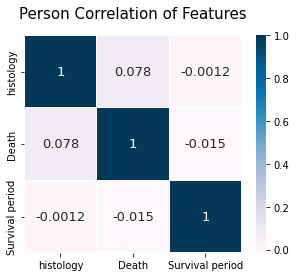

In [10]:
# histology와 Death, Survival period 사이의 상관관계 분석

# Heatmap (Pearson 상관계수)
heatmap_data = pd.concat([colorectal_x['histology'], colorectal_death, colorectal_survival],axis=1)

colormap = plt.cm.PuBu 
plt.figure(figsize=(5,4)) 
plt.title("Person Correlation of Features", y = 1.05, size = 15) 
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, 
            vmax = 1.0, square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 13})

In [11]:
# p-value를 통해 상관관계가 유의미한지 확인
# 피어슨 상관계수 '검정'
corr1 = stats.pearsonr(colorectal_x['histology'], colorectal_death)
corr2 = stats.pearsonr(colorectal_x['histology'], colorectal_survival)
print("histology - Death 상관계수, p-value:",corr1)
print("histology - Survival period 상관계수, p-value:",corr2)

# 왼쪽: 상관계수, 오른쪽: p-value

## corr1
## p-value <= alpha(=0.05) 이므로 두 변수 간에 유의한 상관관계가 있다. 
## 하지만 상관계수는 0.07로 크지 않기 때문에 약한 양의 상관관계가 있다고 할 수 있다.

## corr2
## p-value > alpha(=0.05) 이므로 두 변수 간 상관관계가 통계적으로 유의하지 않다.

histology - Death 상관계수, p-value: (0.07798361911993867, 1.1244505338035725e-21)
histology - Survival period 상관계수, p-value: (-0.0011705509559522794, 0.8860131929523755)


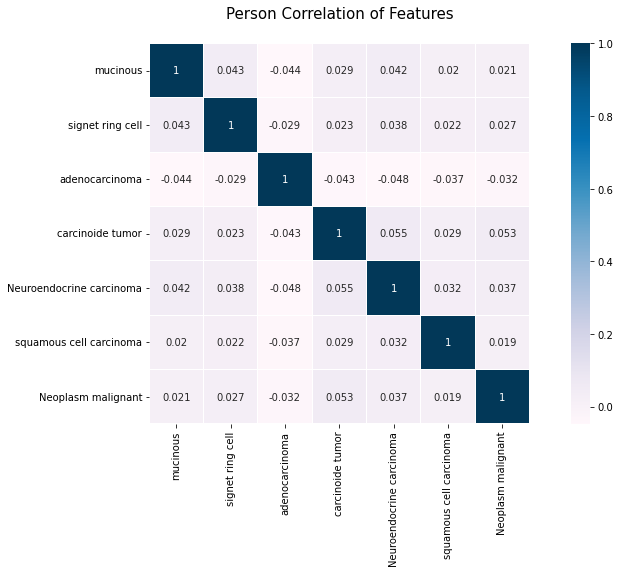

In [12]:
# 컬럼 2~8 각 항목 간 상관계수

# Heatmap (Pearson 상관계수)
heatmap_data = colorectal_x.iloc[:,2:9]

colormap = plt.cm.PuBu 
plt.figure(figsize=(15,7)) 
plt.title("Person Correlation of Features", y = 1.05, size = 15) 
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, 
            vmax = 1.0, square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})

## adenocarcinoma 를 제외한 컬럼들은 서로 약한 양의 상관관계가 있음
## adenocarcinoma 컬럼은 다른 컬럼들과 약한 음의 상관관계가 있음

In [13]:
df_histology = pd.DataFrame()
df_histology['SURVIVE'] = colorectal_death.map({0:"SURVIVED", 1:"DEAD"})
df_histology['HISTOLOGY'] = colorectal_x.histology
df_histology['PERIOD'] = colorectal_survival

In [14]:
df_histology

,SURVIVE,HISTOLOGY,PERIOD
0,SURVIVED,1,907
1,SURVIVED,1,420
2,DEAD,1,441
3,SURVIVED,2,943
4,SURVIVED,1,262
...,...,...,...
14995,SURVIVED,2,1551
14996,SURVIVED,2,285
14997,SURVIVED,2,251
14998,SURVIVED,4,420


(1) histology(Numeric) - Death(Categorical) : Box plot (카테고리별 통계값)

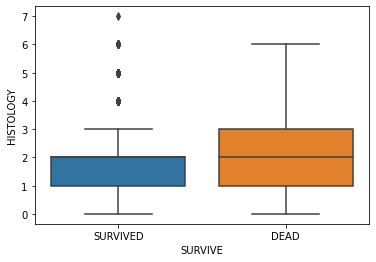

In [15]:
# colorectal_x['histology']의 값: 0,1,2,3,4,5,6,7
# 0~7 : 계층이 있는 양적 변수(Numeric) - 이산형 데이터 

sns.boxplot(x="SURVIVE",
            y="HISTOLOGY",
            data = df_histology)

## 알 수 있는 점
## DEAD인 경우가 SURVIVED보다 HISTOLOGY 개수가 더 많 높게 분포함.

(2) histology(Categorical) - Death(Categorical) : Mosaic plot (교차테이블)

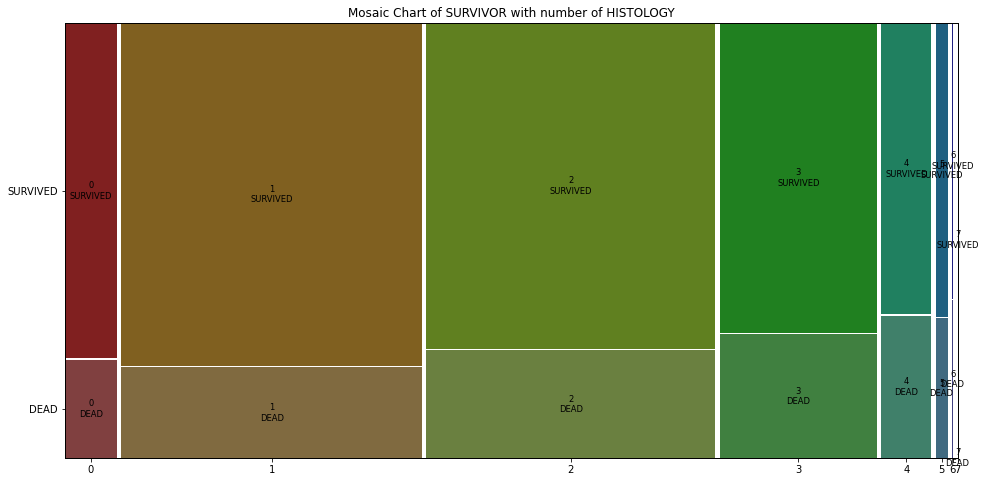

In [16]:
# colorectal_x['histology']의 값: 0,1,2,3,4,5,6,7
# 0~7 : 명목형 변수

plt.rcParams['figure.figsize'] = [16, 8]
mosaic(df_histology.sort_values('HISTOLOGY'),['HISTOLOGY','SURVIVE'],
       title = 'Mosaic Chart of SURVIVOR with number of HISTOLOGY')
plt.show()

## 알 수 있는 점
## DEAD보다 SURVIVED의 비율이 더 많음
## HISTOLOGY의 값이 커질수록(개수 많을수록) DEAD의 비율이 조금씩 증가함 (HISTOLOGY:7은 제외. 표본 수가 적음)

(3) histology(Categorical) - Survival period(Numeric) : Box plot (카테고리별 통계값)

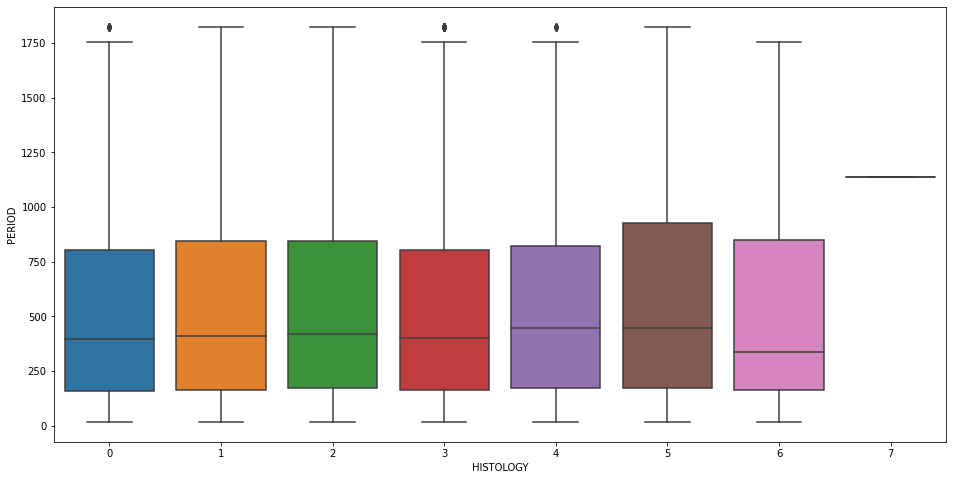

In [17]:
sns.boxplot(x="HISTOLOGY",
            y="PERIOD",
            data = df_histology)

## 알 수 있는 점
## HISTOLOGY값과 PERIOD 평균값(Q2)이 선형관계를 가지지 않음

#### 가설2) 
조직학적 진단 코드값 중 1(1:예)의 개수가 많을수록 계산된 암 병기값이 높을 것이다. 

* 암 병기값 분류를 위해 TNM 병기 값 전처리 **(preprocessing/stage.py - Preprocess)**

  * T4 == 1 → T4a == 1 로 간주
  * N2 == 1 → N2a == 1 로 간주
  * N2c == 1 → N2b == 1로 간주  
      
  * T1,T1a,T1b,T1c → T1 으로 간주
  * T2,T2a,T2b,T2C → T2 로 간주
  * T3,T3a,T3b → T3 로 간주
  * N1,N1a,N1b,N1c → N1 으로 간주


<대장암 병기 4단계 구분>  **(preprocessing/stage.py - Classify)**
<img src="https://user-images.githubusercontent.com/78155086/134316057-d35bcaf5-234a-4db7-b2af-8c3e593bde07.PNG" width="70%">

* 종양(T)의 크기나 범위  
  - T1, T2, T3, T4 사용
* 림프절 전이 여부(N)
  - N0, N1, N2 사용 (N3 사용 X)
* 원격 전이 여부(M)
  - T, N 병기에 상관없이 원격전이 있을 시 4기  


In [18]:
from preprocessing.stage import Preprocess, Classify

df_TNM = colorectal_x.iloc[:,9:39]
df_TNM['Stage'] = np.NaN   # Stage 열 추가 (초기값: NaN)

# 암 병기값 분류를 위해 TNM 병기 값 전처리 (예: 사용 안되는 컬럼값의 값들을 유사한 컬럼에 더해주기)
df_TNM = Preprocess(df_TNM)

# 암 병기값 분류
df_TNM = Classify(df_TNM)

# df_TNM['Stage']의 NaN값을 0으로 대체
df_TNM['Stage'].fillna(0, inplace=True)

series_stage = df_TNM['Stage']

In [19]:
df_stage = pd.DataFrame()
df_stage['HISTOLOGY'] = colorectal_x.histology
df_stage['STAGE'] = series_stage

df_stage

,HISTOLOGY,STAGE
0,1,4.0
1,1,4.0
2,1,4.0
3,2,1.0
4,1,4.0
...,...,...
14995,2,4.0
14996,2,4.0
14997,2,4.0
14998,4,3.3


Histology - Stage 상관관계

In [20]:
corr = stats.pearsonr(df_stage['HISTOLOGY'],df_stage['STAGE'])

print("Histology - Stage 상관계수, p-value:",corr)

# Histology와 Stage는 약한 양의 상관관계가 있음 (p-value < 0.05 이므로 유의한 결과)

Histology - Stage 상관계수, p-value: (0.10593499867906545, 1.0751961319062448e-38)


Histology (Numeric) - Stage (Numeric) : 산점도 (jitter plot)

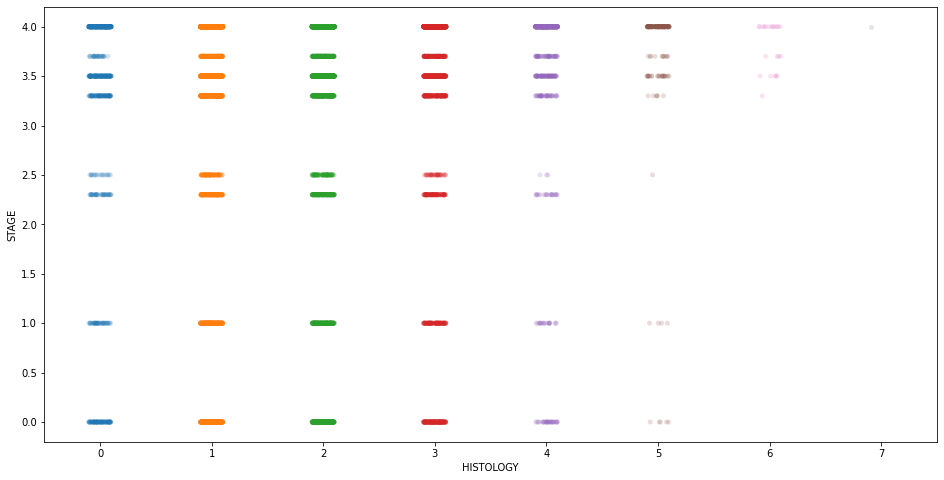

In [23]:
## Histology와 Stage 모두 계층이 있는 이산형 양적 변수

import seaborn as sns
ax = sns.stripplot(x="HISTOLOGY", y="STAGE", data=df_stage, size = 5, jitter = 0.1, alpha=0.2)

## 알 수 있는 점
## HISTOLOGY 개수가 많은 경우에 높은 암 병기값을 가짐.

Stage (Numeric) - Histology (Numeric) : 산점도 (jitter plot)

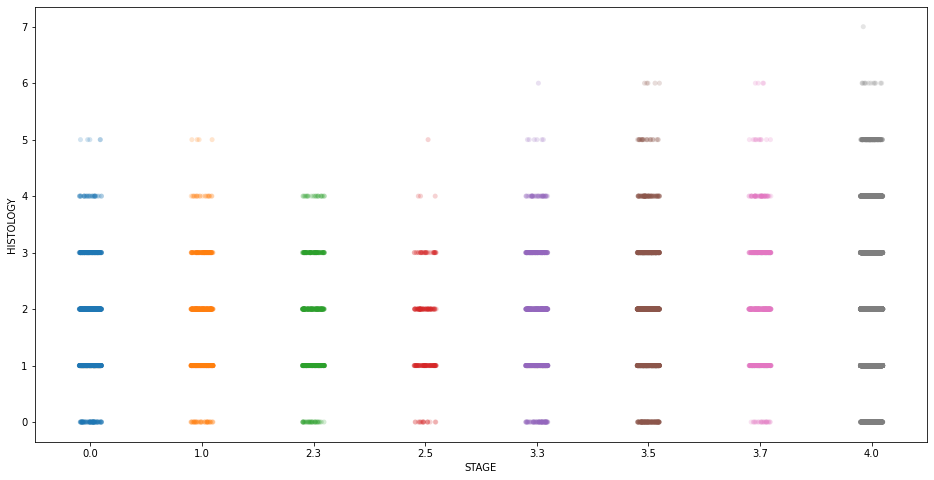

In [24]:
ax = sns.stripplot(x="STAGE", y="HISTOLOGY", data=df_stage, size = 5, jitter = 0.1, alpha=0.2)
## 알 수 있는 점
# 또한, STAGE가 높아질수록 HISTOLOGY 값이 높은 경우가 많음

In [25]:
# 시각화를 위해 각 값을 설명으로 바꾸기
df_stage['STAGE'] = df_stage['STAGE'].map({0:"0기", 1.0:"1기", 2.3:"2기(A)", 2.5:"2기(B)", 2.7:"2기(C)",
                                        3.3:"3기(A)", 3.5:"3기(B)", 3.7:"3기(C)", 4.0:"4기"})

Histology (Numeric) - Stage (Categorical) - Box plot

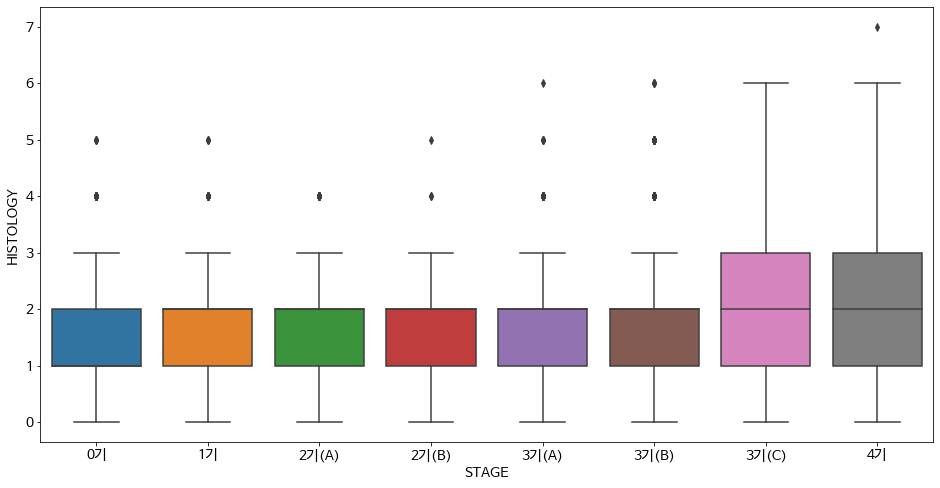

In [27]:
# 암 병기값을 Categorical 변수로 취급

sns.boxplot(x="STAGE",
            y="HISTOLOGY",
            data = df_stage,
            order = ['0기','1기','2기(A)','2기(B)','3기(A)','3기(B)','3기(C)','4기'])
plt.rc('font',family = 'NanumBarunGothic', size=14)

# 알 수 있는 점
# 4기로 갈수록 HISTOLOGY 개수가 더 높은곳에 분포함

HISTOLOGY (Categorical) - STAGE (Categorical) - Mosaic plot

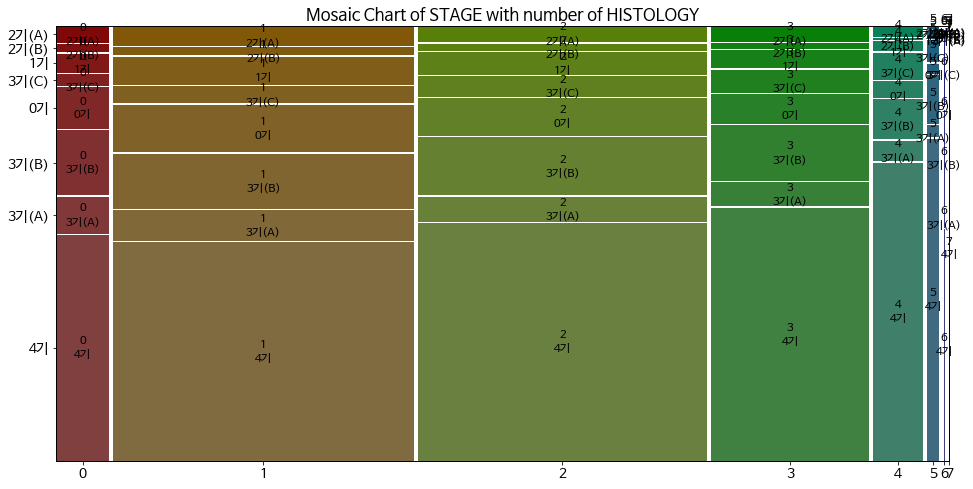

In [30]:
## HISTOLOGY 과 STAGE 를 Categorical 변수로 보기
plt.rcParams['figure.figsize'] = [16, 8]
mosaic(df_stage.sort_values('HISTOLOGY'),['HISTOLOGY','STAGE'],
       title = 'Mosaic Chart of STAGE with number of HISTOLOGY')
plt.show()

## 알 수 있는 점
## Histology 개수가 많을수록 4기의 비율이 높아짐

#### 가설3) 
음주와 흡연을 할 수록 사망 비율이 높고 암 진단후 생존일수가 더 짧을 것이다.

In [31]:
df_smk_drk = pd.DataFrame()
df_smk_drk['DRINK'] = colorectal_x['Type of Drink'].map({1:"맥주",2:"소주",3:"양주",99:"기타"})
df_smk_drk['SMOKE'] = colorectal_x['Smoke'].map({0:"비흡연",1:"현재흡연",2:"과거흡연"})
df_smk_drk['SURVIVE'] = colorectal_death.map({0:"SURVIVED", 1:"DEAD"})
df_smk_drk['PERIOD'] = colorectal_survival
df_smk_drk

,DRINK,SMOKE,SURVIVE,PERIOD
0,양주,비흡연,SURVIVED,907
1,기타,비흡연,SURVIVED,420
2,기타,과거흡연,DEAD,441
3,기타,비흡연,SURVIVED,943
4,기타,과거흡연,SURVIVED,262
...,...,...,...,...
14995,소주,비흡연,SURVIVED,1551
14996,기타,현재흡연,SURVIVED,285
14997,기타,비흡연,SURVIVED,251
14998,기타,과거흡연,SURVIVED,420


Type of Drink(Categorical) - Death(Categorical) : Mosaic plot

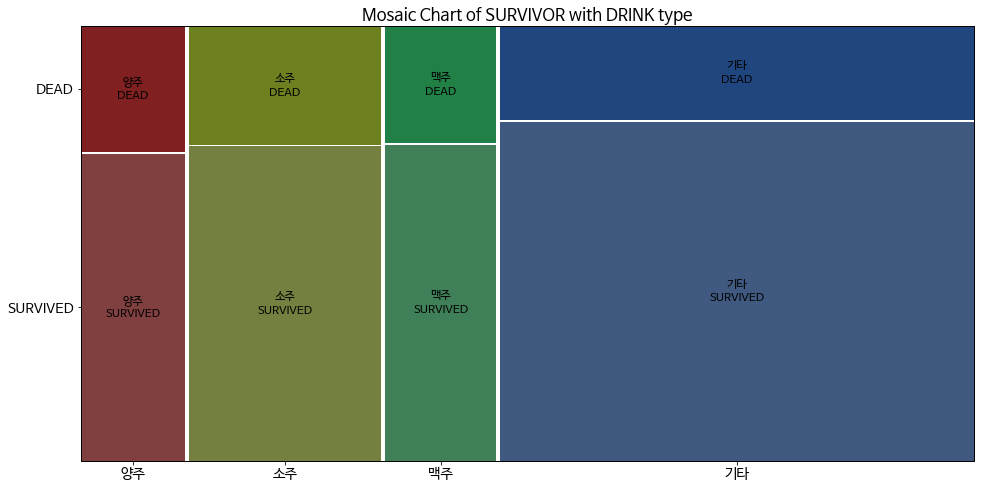

In [33]:
mosaic(df_smk_drk.sort_values('DRINK',ascending=False),['DRINK','SURVIVE'],
       title = 'Mosaic Chart of SURVIVOR with DRINK type')
plt.rc('font',family = 'NanumBarunGothic', size=14)
plt.show()
plt.rcParams['figure.figsize'] = [12, 7]


## 알 수 있는 점
## 기타가 가장 DEAD 비율이 적은 것을 봤을 때 음주 하지 않는 사람은 기타로 분류했을 가능성이 높아 보임.
## 양주, 소주, 맥주 비교 : 도수가 센 술(양주 > 소주 > 맥주)일수록 DEAD 비율이 높음.

Type of Drink(Categorical) - Survival Period(Numeric) : Box plot

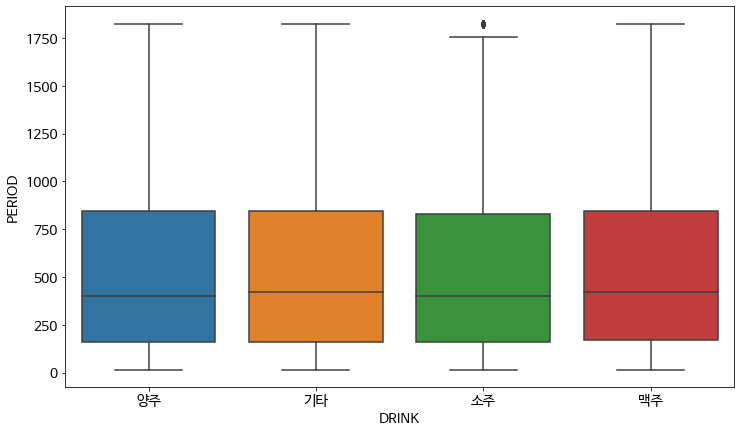

In [34]:
sns.boxplot(x="DRINK",
            y="PERIOD",
            data=df_smk_drk)
## 알 수 있는 점
## 도수가 센 술을 마실수록 PERIOD 길이가 미세하게 짧아짐

In [35]:
# DRINK 종류별 PERIOD 평균값
print("DRINK=='양주'집단의 PERIOD 평균 :",df_smk_drk[df_smk_drk['DRINK']=='양주']['PERIOD'].mean())
print("DRINK=='소주'집단의 PERIOD 평균 :",df_smk_drk[df_smk_drk['DRINK']=='소주']['PERIOD'].mean())
print("DRINK=='맥주'집단의 PERIOD 평균 :",df_smk_drk[df_smk_drk['DRINK']=='맥주']['PERIOD'].mean())
print("DRINK=='기타'집단의 PERIOD 평균 :",df_smk_drk[df_smk_drk['DRINK']=='기타']['PERIOD'].mean())

DRINK=='양주'집단의 PERIOD 평균 : 548.1636466591167
DRINK=='소주'집단의 PERIOD 평균 : 549.7021081576536
DRINK=='맥주'집단의 PERIOD 평균 : 553.1498147167814
DRINK=='기타'집단의 PERIOD 평균 : 553.1419722497523


In [36]:
df_smk_drk['SMOKE'].value_counts()

비흡연     9988
과거흡연    2516
현재흡연    2496
Name: SMOKE, dtype: int64

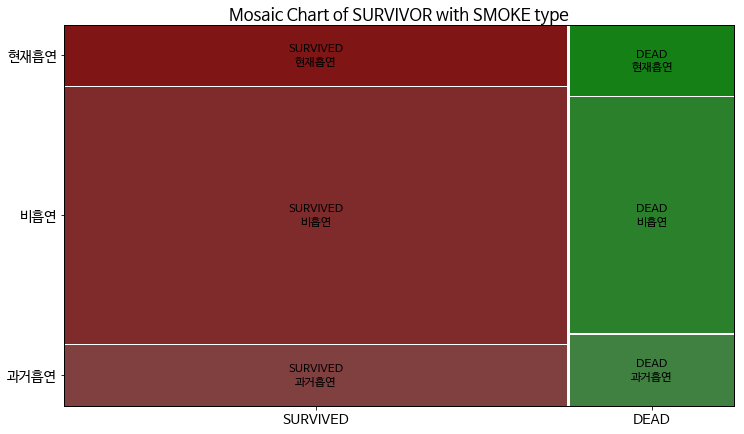

In [37]:
## Smoke(Categorical) - Death(Categorical) : Mosaic plot
mosaic(df_smk_drk.sort_values('SMOKE'),['SURVIVE','SMOKE'],
       title = 'Mosaic Chart of SURVIVOR with SMOKE type')
#mosaic(df_smk_drk.sort_values('SMOKE'),['SMOKE','SURVIVE'],
#       title = 'Mosaic Chart of SURVIVOR with SMOKE type')
plt.show()
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font',family = 'NanumBarunGothic', size=14)

## 알 수 있는 점
## DEAD의 경우 SURVIVED보다 현재흡연, 과거흡연의 비율이 높음.

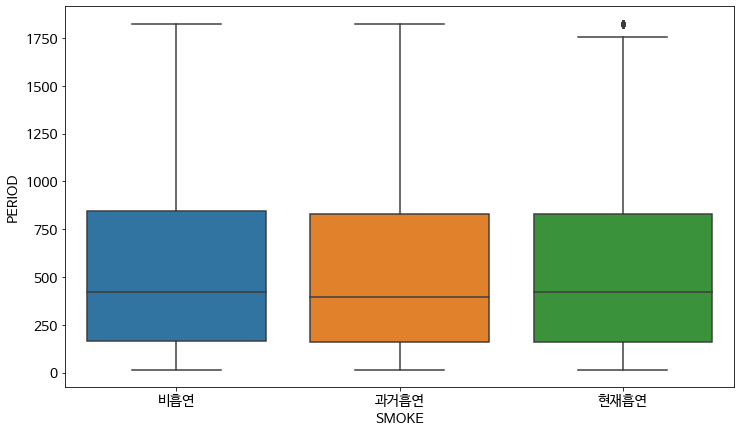

In [38]:
## Smoke (Categorical) - Survival Period(Numeric)
sns.boxplot(x="SMOKE",
            y="PERIOD",
            data=df_smk_drk)
## 알 수 있는 점
## 과거흡연의 경우 다른 경우에 비해 생존 기간의 Q2값이 더 작고, Q1~Q3 구간이 미세하게 더 작은 쪽에 위치함.
# 비흡연, 현재 흡연은 큰 차이가 없음.

#### 가설4)
TNM병기 조합으로부터 계산된 암 병기의 값(1~4)이 클 수록 사망인 경우가 많을 것이고, 암 진단 후 생존일수가 짧을 것이다.

In [41]:
# Stage와 Death간 상관관계
corr1 = stats.pearsonr(series_stage, colorectal_death)
print("Stage와 Death 간 상관계수, p-value :", corr1)  # 유의함, 0.06 -> 약한 양의 상관관계를 가짐

# Stage와 Survival Period간 상관관계
corr2 = stats.pearsonr(series_stage, colorectal_survival)
print("Stage와 Survival Period 간 상관계수, p-value :", corr2)  # 유의하지 않음

Stage와 Death 간 상관계수, p-value : (0.06886759534311412, 3.0706312480986396e-17)
Stage와 Survival Period 간 상관계수, p-value : (0.0030906151575102003, 0.7050659782320344)


In [46]:
df_stage = pd.DataFrame()
df_stage['STAGE'] = df_TNM['Stage'].map({0:"0기", 1.0:"1기", 2.3:"2기(A)", 2.5:"2기(B)", 2.7:"2기(C)",
                                         3.3:"3기(A)", 3.5:"3기(B)", 3.7:"3기(C)", 4.0:"4기"})
df_stage['SURVIVE'] = colorectal_death.map({0:"SURVIVED", 1:"DEAD"})
df_stage['PERIOD'] = colorectal_survival

df_stage

,STAGE,SURVIVE,PERIOD
0,4기,SURVIVED,907
1,4기,SURVIVED,420
2,4기,DEAD,441
3,1기,SURVIVED,943
4,4기,SURVIVED,262
...,...,...,...
14995,4기,SURVIVED,1551
14996,4기,SURVIVED,285
14997,4기,SURVIVED,251
14998,3기(A),SURVIVED,420


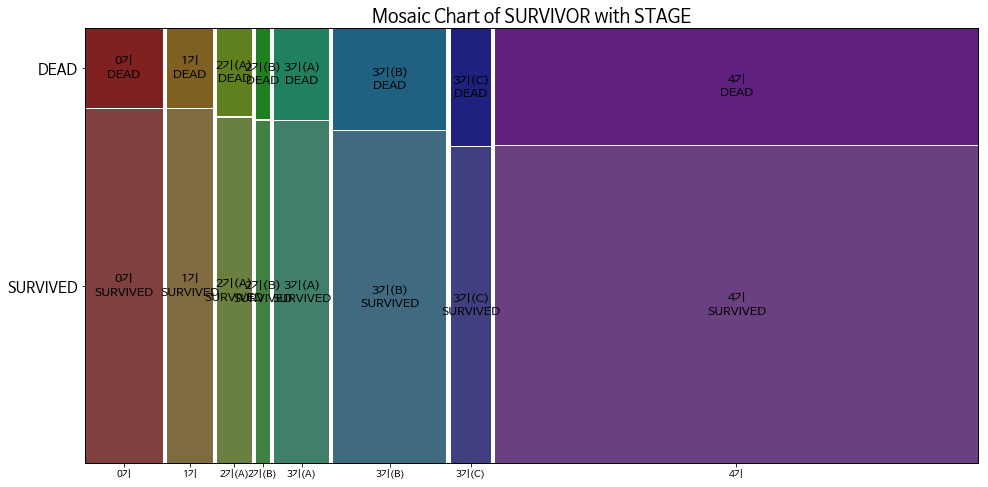

In [43]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rc('font', size=15)
plt.rc('xtick', labelsize=10)
mosaic(df_stage.sort_values('STAGE'),['STAGE','SURVIVE'],
       title = 'Mosaic Chart of SURVIVOR with STAGE')
plt.show()
# 알 수 있는 점
# 환자들 중 4기의 비율이 제일 높음
# 4기로 갈 수록 DEAD 비율이 높아짐

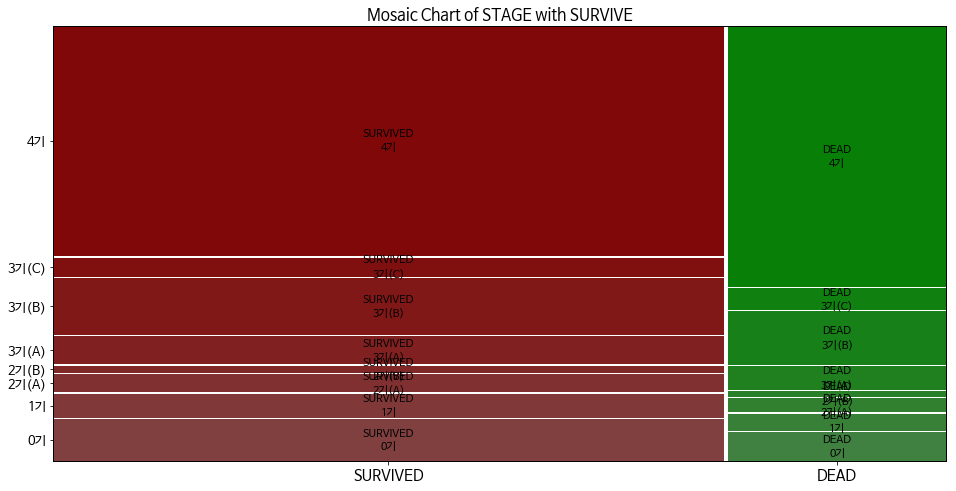

In [44]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rc('font', size=13)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=13)
mosaic(df_stage.sort_values('STAGE'),['SURVIVE','STAGE'],
       title = 'Mosaic Chart of STAGE with SURVIVE')
plt.show()
# 알 수 있는 점
# DEAD의 절반 이상이 4기였음.

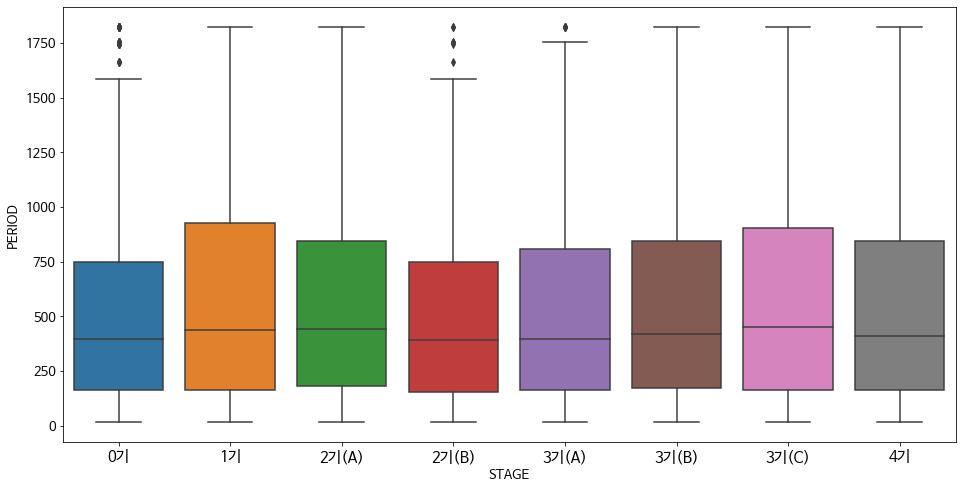

In [45]:
sns.boxplot(x="STAGE",
            y="PERIOD",
            data = df_stage, order = ['0기','1기','2기(A)','2기(B)','3기(A)','3기(B)','3기(C)','4기'])
# 알 수 있는 점
# 병기별로 Survival Period가 크게 다르지 않음